In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
main_df = pd.read_pickle('main_df.pickle')
main_df

,id,subreddit,title,selftext,genre
0,6d8knd,talesfromtechsupport,remember your command line switches,"""hi there """,writing/stories
1,58mbft,teenmom,"""so what was matt """"addicted"""" to ? """,did he ever say what his addiction was or is h...,tv_show
2,8f73s7,Harley,no club colors,funny story i went to college in las vegas thi...,autos
3,6ti6re,ringdoorbell,not door bell but floodlight mount height,i know this is a sub for the 'ring doorbell' b...,hardware/tools
4,77sxto,intel,worried about my 8700k small fft/data stress r...,"""prime95 (regardless of version) and occt both...",electronics
...,...,...,...,...,...
1012995,5r9k4h,MSLGame,is this months rebirth and dungeon astro's wor...,i looking on what to evo3 farm next and was ex...,video_game
1012996,6529fp,CrohnsDisease,i might need a medical leave from grad school,has anyone here ever needed a medical leave fr...,health
1012997,7tiyzx,HongKong,police harassing ethnic minorities in hong kong,i thought i'd make this post so that more peop...,geo
1012998,664ha3,yorku,su eecs 2030 and eecs 2021 - need advice,hi i just finished 1st year eecs courses and h...,education


In [5]:
sampled_data = []
for genre in main_df['genre'].unique():
    genre_data = main_df[main_df['genre'] == genre].sample(n=3000, random_state=42)
    sampled_data.append(genre_data)

In [6]:
main_df_sampled = pd.concat(sampled_data)
main_df_sampled = main_df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
preprocessed = [simple_preprocess(x) for x in tqdm(main_df_sampled['title'] + " " + main_df_sampled['selftext'])]


100%|██████████| 117000/117000 [00:18<00:00, 6366.68it/s]


In [8]:
word2vec_model = Word2Vec(sentences=preprocessed, vector_size=300, window=5, min_count=1, workers=4)

In [9]:
# Convert texts to average Word2Vec embeddings
def get_word2vec_embeddings(texts):
    embeddings = []
    for text in texts:
        vector = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
        if vector:
            embeddings.append(np.mean(vector, axis=0))
        else:
            embeddings.append(np.zeros(300))  # Handling empty vectors
    return np.array(embeddings)

In [10]:
X_word2vec = get_word2vec_embeddings(preprocessed)
y = main_df_sampled['genre'].copy()

In [11]:
# Encoding labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y_encoded, test_size=0.2, random_state=42)


In [13]:
# Reshaping data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
# LSTM Model
model = Sequential()
model.add(LSTM(100, input_shape=(1, 300)))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_split=0.2)


Epoch 1/10
1170/1170 [==============================] - 17s 10ms/step - loss: 2.8443 - accuracy: 0.2273 - val_loss: 2.4823 - val_accuracy: 0.3196
Epoch 2/10
1170/1170 [==============================] - 11s 9ms/step - loss: 2.5408 - accuracy: 0.2995 - val_loss: 2.3924 - val_accuracy: 0.3456
Epoch 3/10
1170/1170 [==============================] - 11s 9ms/step - loss: 2.4786 - accuracy: 0.3151 - val_loss: 2.3518 - val_accuracy: 0.3548
Epoch 4/10
1170/1170 [==============================] - 10s 9ms/step - loss: 2.4426 - accuracy: 0.3237 - val_loss: 2.3353 - val_accuracy: 0.3551
Epoch 5/10
1170/1170 [==============================] - 15s 12ms/step - loss: 2.4123 - accuracy: 0.3291 - val_loss: 2.2998 - val_accuracy: 0.3629
Epoch 6/10
1170/1170 [==============================] - 10s 9ms/step - loss: 2.3897 - accuracy: 0.3375 - val_loss: 2.2833 - val_accuracy: 0.3675
Epoch 7/10
1170/1170 [==============================] - 12s 10ms/step - loss: 2.3709 - accuracy: 0.3414 - val_loss: 2.2639 - val

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test)
print("Test Accuracy:", accuracy)

732/732 [==============================] - 2s 3ms/step - loss: 2.2424 - accuracy: 0.3738
Test Accuracy: 0.3738461434841156


In [18]:
# Predict output probabilities
probabilities = model.predict(X_test_lstm)

732/732 [==============================] - 8s 7ms/step


In [19]:
# Convert probabilities to class labels
y_pred = np.argmax(probabilities, axis=1)

In [20]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

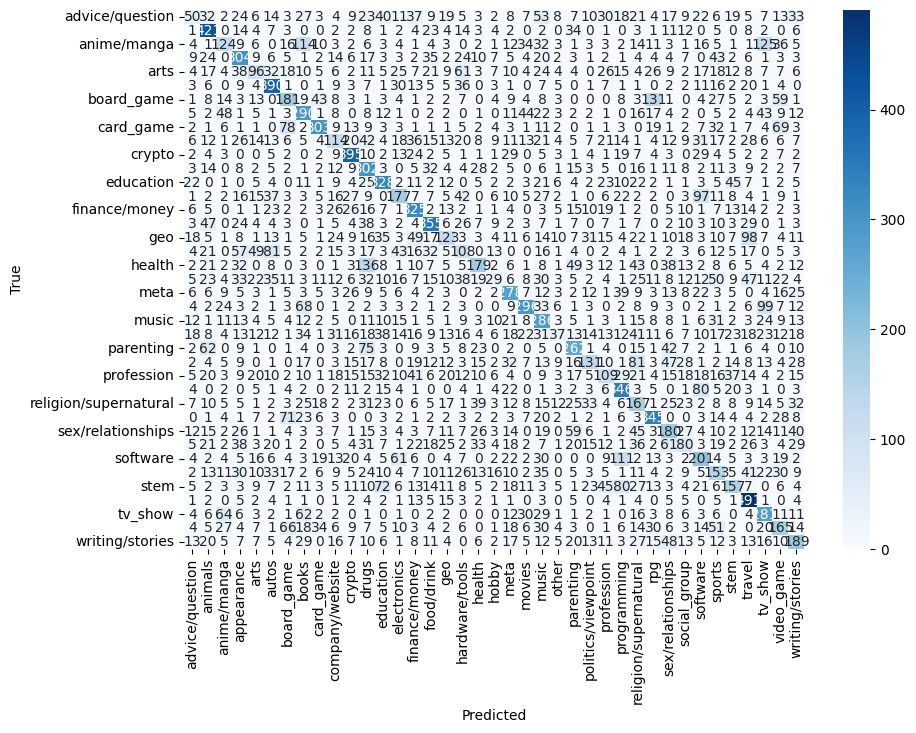

In [21]:
plot_confusion_matrix(y_test, y_pred)

In [22]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


                       precision    recall  f1-score   support

      advice/question       0.19      0.08      0.11       620
              animals       0.49      0.70      0.57       604
          anime/manga       0.31      0.20      0.24       621
           appearance       0.38      0.51      0.44       598
                 arts       0.26      0.16      0.20       584
                autos       0.49      0.64      0.56       607
           board_game       0.34      0.31      0.33       575
                books       0.35      0.49      0.41       589
            card_game       0.61      0.50      0.54       612
      company/website       0.26      0.19      0.22       605
               crypto       0.57      0.65      0.61       608
                drugs       0.30      0.55      0.39       545
            education       0.45      0.54      0.49       609
          electronics       0.35      0.30      0.32       591
        finance/money       0.44      0.56      0.49  

In [17]:
# Prediction and metrics
y_pred = model.predict_classes(X_test_lstm)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# Output classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))